In [1]:
import os
import sys

import cv2
import toml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from multiprocessing import Pool

from tqdm import tqdm_notebook as tqdm

sys.path.append('..')
from utils.io import rle_decode

In [2]:
TRAIN_DIR = '../../data/dataset/train_768'
MASKS_DF = '../../data/dataset/train_ships_768.csv'

FOLDS_DF = '../../data/dataset/folds_768.csv'
N_FOLDS = 5

In [195]:
# read train data
df = pd.read_csv(MASKS_DF)

print(df.shape[0], '- rle masks found')
print(df['ImageId'].value_counts().shape[0], '- images found')
df.head()

182672 - rle masks found
173634 - images found


EncodedPixels     ImageId big_image_id  black_rate
0           NaN  0s0xVjUc4w   000000.jpg    0.000000
1           NaN  lCoHXnbeyF   000000.jpg    0.109597
2           NaN  pNNFnPBQmL   000000.jpg    0.000000
3           NaN  6cr6xRZyRa   000001.jpg    0.000000
4           NaN  VK9iY8pCld   000001.jpg    0.000000

In [196]:
# tag images with ships and ship size
df['has_ship'] = df['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
df['ship_size'] = df['EncodedPixels'].map(
    lambda x: rle_decode(x, shape=(768, 768)).sum() if isinstance(x, str) else 0)
df.head()

EncodedPixels     ImageId big_image_id  black_rate  has_ship  ship_size
0           NaN  0s0xVjUc4w   000000.jpg    0.000000         0          0
1           NaN  lCoHXnbeyF   000000.jpg    0.109597         0          0
2           NaN  pNNFnPBQmL   000000.jpg    0.000000         0          0
3           NaN  6cr6xRZyRa   000001.jpg    0.000000         0          0
4           NaN  VK9iY8pCld   000001.jpg    0.000000         0          0

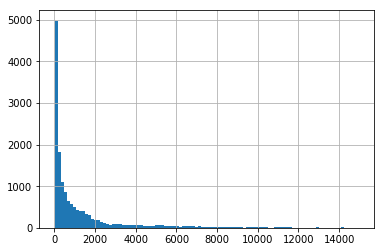

In [197]:
ships_df = df[df['ship_size'] > 0]
ships_df[ships_df['ship_size'] < 15000]['ship_size'].hist(bins=100)
plt.show()

In [198]:
# new data frame with unique image ids and aggregate statistics
new_df = pd.DataFrame(index=df['ImageId'].unique())

# count ships for each image
new_df['n_ships'] = (df.groupby('ImageId')
                     .agg({'has_ship': 'sum'})
                     .reset_index()
                     .set_index('ImageId'))['has_ship']

# count total area of ships on image
new_df['ships_area'] = (df.groupby('ImageId')
                        .agg({'ship_size': 'sum'})
                        .reset_index()
                        .set_index('ImageId'))['ship_size']

# count mean ship area on image
new_df['mean_ship_area'] = (df.groupby('ImageId')
                  .agg({'ship_size': 'mean'})
                  .reset_index()
                  .set_index('ImageId'))['ship_size']

In [199]:
new_df[new_df['n_ships'] > 7].sample(10)

n_ships  ships_area  mean_ship_area
yrS9XbIIXX       18       15776      876.444444
pRbDJOOx4v       14       18717     1336.928571
tNngfQSw5p       16        2686      167.875000
cRzRk5UDlE        9       15237     1693.000000
CgHpyvZTWm        9        4197      466.333333
UP8lCjHvf0       14        5420      387.142857
RqvzFte2t3       13        3016      232.000000
nLXZYDg5SY        9        5326      591.777778
sCaX5LrjQH        9        7674      852.666667
97pAEe3MtF       11       10146      922.363636

In [200]:
ships_df = new_df[new_df['n_ships'] > 0]
no_ships_df = new_df[new_df['n_ships'] == 0]

print('Images with ships', ships_df.shape[0])
print('Images without ships', no_ships_df.shape[0])
print('Total images: {} + {} = {} == {}'.format(ships_df.shape[0], no_ships_df.shape[0],
                                               ships_df.shape[0] + no_ships_df.shape[0],
                                               new_df.shape[0]))

Images with ships 6492
Images without ships 167142
Total images: 6492 + 167142 = 173634 == 173634


# mozaik stratified split

In [201]:
def func(n):
#     folds = np.random.permutation(np.arange(N_FOLDS))
#     rep = (n - 1) // N_FOLDS + 1
#     folds = np.tile(folds, rep).reshape(rep,-1).flatten('F')
#     return folds[:n]
    folds = np.random.permutation(np.arange(N_FOLDS))
    rep = (n - 1) // N_FOLDS + 1
    arr = np.tile(folds, rep)
    arr[n:] = -1
    arr = arr.reshape(rep,-1).flatten('F')
    arr = arr[arr != -1]
    assert len(arr) == n
    return arr

In [202]:
folds_df = df[['ImageId', 'big_image_id']].drop_duplicates('ImageId')

In [203]:
b_image_id = df.iloc[0]['big_image_id']

counter = 0
global_folds = []

for i, sample in folds_df.iterrows():
    
    #print(sample['big_image_id'], b_image_id)
    if sample['big_image_id'] != b_image_id:
        
        folds = func(counter)
        global_folds.extend(folds)
        #print(folds, counter, i+1, len(global_folds))
        
        b_image_id = sample['big_image_id']
        counter = 1
        
    else:
        counter += 1

folds = func(counter)
global_folds.extend(folds)

In [204]:
folds_df['fold'] = global_folds

In [212]:
new_df = new_df.reset_index().rename(columns={'index': 'ImageId'})

In [214]:
new_df = pd.merge(new_df, folds_df)

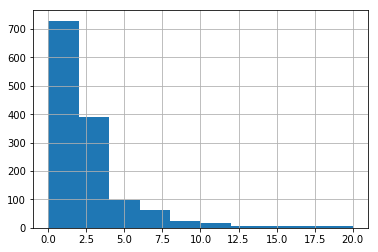

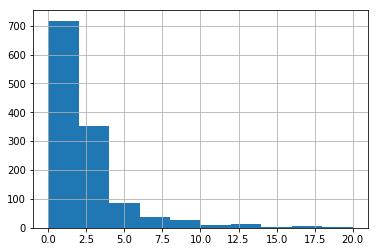

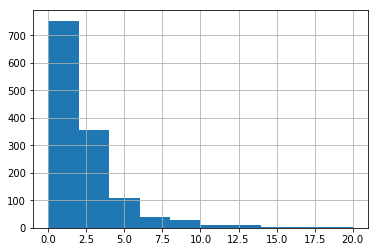

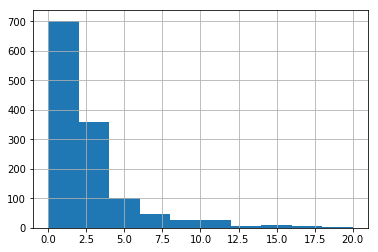

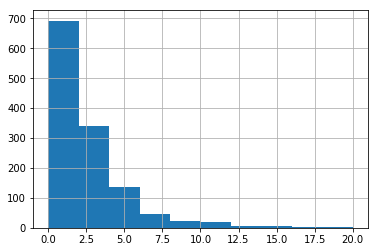

In [221]:
for fold in range(N_FOLDS):
    _df = new_df[new_df['fold'] == fold]
    _df[_df['n_ships'] > 0]['n_ships'].hist(range=(0, 20))
    plt.show()

In [228]:
folds_df.to_csv('../../data/dataset/folds_768.csv', index=False)

## Splitting ships dataset

In [10]:
np.linspace(0, 100, 20+1)

array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.])

In [11]:
def bin_column(df, column, bins=20):
    
    values = pd.to_numeric(df[column].values)
    
    labels = np.arange(bins)
    
    for i in range(0, 1000, 10):
        groups = [0] + [np.percentile(values, p) for p in np.linspace(0, 100, bins+i)]
        groups = np.unique(groups)
        if len(groups) >= bins:
            break
            
    labels = np.arange(len(groups) - 1)
    
    df['binned_'+column] = pd.cut(df[column], bins=groups, labels=labels)
    return df

In [19]:
ships_df = bin_column(ships_df, 'n_ships', 10)
ships_df = bin_column(ships_df, 'ships_area', 10)
ships_df = bin_column(ships_df, 'mean_ship_area', 10)

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
ships_df = ships_df.sort_values(['binned_n_ships', 'binned_ships_area', 'binned_mean_ship_area'])

In [21]:
ships_df['fold'] = (list(range(N_FOLDS))*ships_df.shape[0])[:ships_df.shape[0]]

In [25]:
ships_df

n_ships  ships_area  mean_ship_area  fold binned_n_ships  \
Wv87ITIRKe        1           5        5.000000     0              0   
1f3udHMpuX        1          70       70.000000     1              0   
YsBQfcr4th        1          39       39.000000     2              0   
Db2KXLZ9TN        1          70       70.000000     3              0   
3ob9oHb5ol        1          63       63.000000     4              0   
PKhAKAQ5jd        1          40       40.000000     0              0   
AkRkDaiZ1C        1          26       26.000000     1              0   
6SnD5KmZgc        1          35       35.000000     2              0   
HKnfVGXEQn        1          36       36.000000     3              0   
VlGPGslUpC        1          31       31.000000     4              0   
8ize9hLAJ4        1          36       36.000000     0              0   
TOgUi3Gl5O        1          63       63.000000     1              0   
eLJWKKPtbs        1          20       20.000000     2              0   
EtSbwu9aqk        1          25       25.000000     3              0   
idVhOhJRU8        1          72       72.000000     4              0   
a3DAJ4rnaM        1          24       24.000000     0              0   
UG017QVJiq        1          42       42.000000     1              0   
FcSrk8FG7J        1          52       52.000000     2              0   
Q0nB9TFSNi        1          29       29.000000     3              0   
cs8ZzL3LVp        1          74       74.000000     4              0   
bf106TphFE        1          23       23.000000     0              0   
43gxz3QAfs        1          33       33.000000     1              0   
3T1mbKcjTp        1          57       57.000000     2              0   
jCJipLVSv4        1          45       45.000000     3              0   
F4geecWxll        1          69       69.000000     4              0   
1dTQ5Gpoda        1          72       72.000000     0              0   
Uqf9BhG2Zp        1          24       24.000000     1              0   
5SIeXBMWXK        1          55       55.000000     2              0   
zlMEYg8dZy        1          54       54.000000     3              0   
bGxsLmxXuL        1           7        7.000000     4              0   
...             ...         ...             ...   ...            ...   
yrS9XbIIXX       18       15776      876.444444     2              8   
XSV1x9kDp2       16       13384      836.500000     3              8   
jgh97uUcVI       13       10454      804.153846     4              8   
3dk8kTz2H0       12        9627      802.250000     0              8   
pRW4PGbKKa       14        9810      700.714286     1              8   
5dKj7MLYll       15       13313      887.533333     2              8   
GZ4VaFntIb       12       11598      966.500000     3              8   
cTbxGtB7JO       17       10685      628.529412     4              8   
OA0y7dGVZN       14       10641      760.071429     0              8   
p1iP1p6WPk       15       12504      833.600000     1              8   
jy0WKnfHtt       12        9944      828.666667     2              8   
44XbnfmttW       24       22666      944.416667     3              8   
abbZ5dqOMe       28       19502      696.500000     4              8   
Y56IKzyPVA       16       13760      860.000000     0              8   
a7XPrXR5j5       17       10493      617.235294     1              8   
stgjrF0ACB       12       13239     1103.250000     2              8   
pRbDJOOx4v       14       18717     1336.928571     3              8   
i6TVCB8981       13       16682     1283.230769     4              8   
VLlHjbIttX       19       22816     1200.842105     0              8   
skLsGBcCm4       14       16298     1164.142857     1              8   
HBQqGdDM6w       16       20060     1253.750000     2              8   
GbmihxjRbo       15       18804     1253.600000     3              8   
ZZ9AGrhzqB       15       25930     1728.666667     4              8   
bgmBhLmQXf       14       24644     1760.285714     

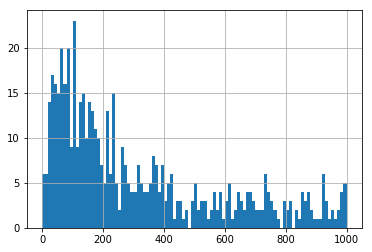

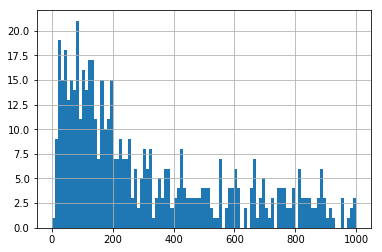

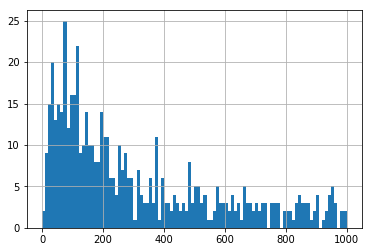

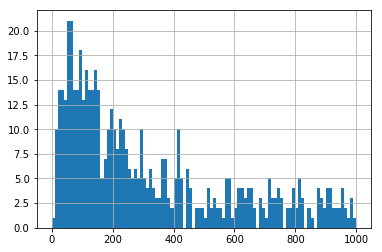

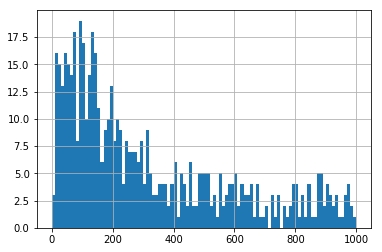

In [24]:
for fold in range(N_FOLDS):
    fold_df = ships_df[ships_df['fold'] == fold]
    fold_df['ships_area'].hist(range=(0, 1000), bins=100)
    plt.show()

### splitting df without ships

In [80]:
no_ships_df['fold'] = (list(range(N_FOLDS))*no_ships_df.shape[0])[:no_ships_df.shape[0]]

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### merging folds

In [81]:
df1 = ships_df[['fold']]
df2 = no_ships_df[['fold']]

folds_df = df1.append(df2)

In [83]:
folds_df.to_csv(FOLDS_DF)

In [85]:
folds_df.shape

(1073309, 1)